In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import networkx as nx
import scipy
from scipy import signal

In [2]:
def construct_graph( n_conn_nodes):
    g =  nx.watts_strogatz_graph(n_conn_nodes, 3, 0.5)  #param: 2, 0.01 ??
    # adj = (nx.adjacency_matrix(g)).toarray()

    sel_sensors = sample_sensors(n_conn_nodes)
    d = dict(zip([i for i in g.nodes()], [int(sel_sensors[j]) for j in range(len(sel_sensors))]))
    g = nx.relabel_nodes(g, d)
    return g

def sample_sensors(n_conn_nodes):
    n = np.random.randint(0,65, size = n_conn_nodes)
    return n


def construct_theta_subblocks(m):
    block = np.eye(m)*0.2
    # block = np.ones((m,m))*3
    return block


def construct_precision_theta(p,m, g):
    delta = 1
    theta = np.eye((m*p))* delta

    # delta = delta+1
    for i in g.edges:
        # print(i)
        theta[i[0]*m:(i[0]+1)*m, i[1]*m:(i[1]+1)*m] = construct_theta_subblocks(m)
        theta[i[1]*m:(i[1]+1)*m, i[0]*m:(i[0]+1)*m] = construct_theta_subblocks(m) #theta[i[0]*m:(i[0]+1)*m, i[1]*m:(i[1]+1)*m]

    #mett controllo per semipositivedefinite    
#put here a code to check condition on delta
    # plt.imshow(theta)
    # plt.show()
    # plt.close()
    # print(len(np.where(theta == 0)[0]))

    while delta <= np.max(np.sum(abs(theta -np.eye(m*p)), axis=0)):
        # print(delta, np.max(np.sum(abs(theta -np.eye(m*p)), axis=0)))
        delta += 1

    theta =  theta + np.eye(m*p)*(delta-1)
    print(delta,np.max(np.sum(abs(theta -np.eye(m*p)), axis=0)))
    # plt.imshow(theta)
    # plt.show()
    # plt.close()
    # print(len(np.where(theta == 0)[0]))

    return theta

In [3]:

def define_func_score(p,m, mu, sigma):
    # mu \in R^{pm} ?
    # sigma = theta^(-1), theta \in R^{pm x om}   
    csi = np.random.multivariate_normal(np.zeros(m*p), sigma).reshape((m,p))

    #NB: di può decidere di richiamare la funzione precision matrix qui per creare theta ed invertirla (bisogna vedere se è utile avere theta nel codice, forse sì)
    return csi


def create_fourier_basis(t, freq_band):
    t = np.array(t)
    fb = np.ones((len(freq_band)*2,len(t)))*(-3)
    k=0
    for f in freq_band:
        fb[k, :] = np.sqrt(f)*np.cos(2*np.pi*f*t)
        fb[k+1, :] = np.sqrt(f)*np.sin(2*np.pi*f*t)
        k = k +2
    return fb    


def func_data(t, freq_band, p, mu, sigma):
    fb_vec = create_fourier_basis(t,freq_band).T   #NB non ottimale la generazione della base a ogni dato funzionale generato 
    # print(fb_vec.shape)
    csi_vec = define_func_score(p,len(freq_band)*2,mu,sigma)
    # print(csi_vec.shape)
    sm = np.matmul(fb_vec, (csi_vec))
    return sm.T

In [8]:
def fdata_sim(n1, n2, p, freq_band, time, sigma_pop, sigma_group1):
    data = np.zeros((p, len(time), (n1+n2)))
    for i in range(n1+n2):
        data[:,:, i] = func_data(time, freq_band, p,  0, sigma_pop)  
        if i < n1:
            data[:, :, i] += func_data(time, freq_band, p,  0, sigma_group1)

    return data
            

1 0.8
True


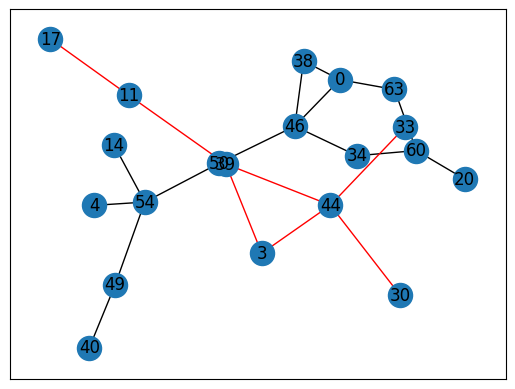

1 0.8


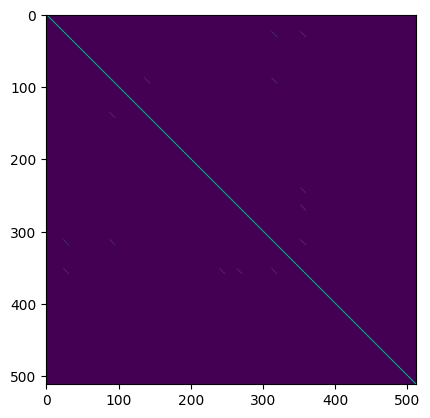

True


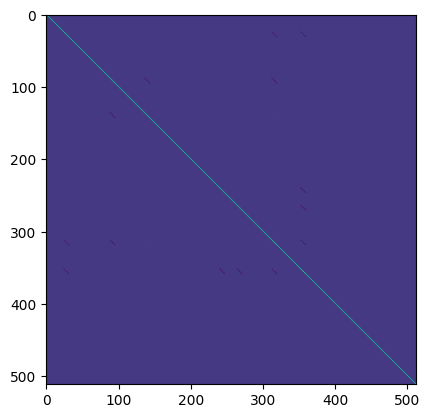

In [ ]:
p = 64; freq = [9,10,11,12]; m= len(freq)*2; n_nodes_active_pop = 15; n_nodes_diff_group = 7
time = np.linspace(0,100,10000)


g = construct_graph(n_nodes_active_pop)

# print(a)
nx.draw_networkx(g, with_labels = True)
# plt.show()
# plt.close()

tp = construct_precision_theta(p,m,g)
# plt.imshow(tp)
# plt.show()
# plt.close()


# while np.all(np.linalg.eigvals(tp) > 0) != True:
print(np.all(np.linalg.eigvals(tp) > 0))
sigma = np.linalg.inv(tp)

# plt.imshow(sigma)
# plt.show()
# plt.close()


g_diff = construct_graph(n_nodes_diff_group)
while len(np.intersect1d(list(g.nodes()), list(g_diff.nodes()))) != 0:
    g_diff = construct_graph(n_nodes_diff_group)


nx.draw_networkx(g_diff, with_labels = True, edge_color = 'r')
plt.show()
plt.close()
   

tp_g1 = construct_precision_theta(p,m,g_diff)
plt.imshow(tp_g1)
plt.show()
plt.close()

print(np.all(np.linalg.eigvals(tp_g1) > 0))
sigma_g1 = np.linalg.inv(tp_g1)
plt.imshow(sigma_g1)
plt.show()
plt.close()


d = fdata_sim(4,3,p, freq,time,sigma, sigma_g1)

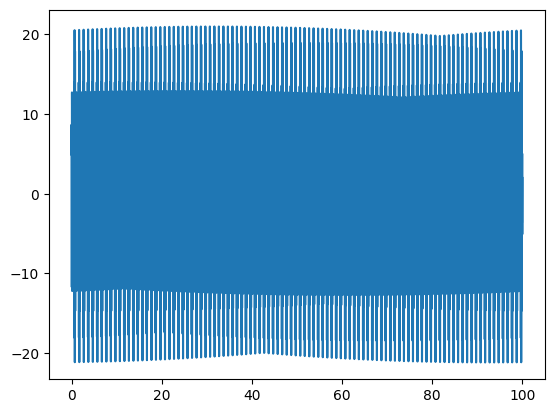

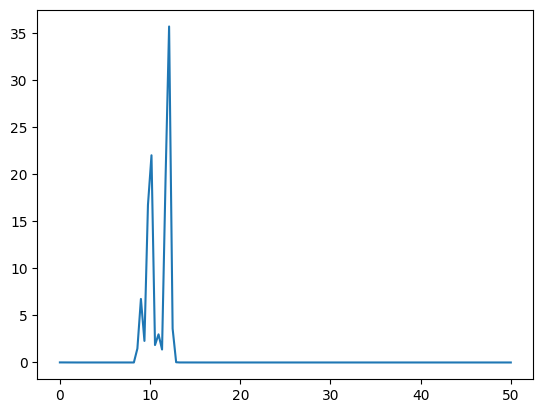

In [21]:
n_ch  = 54

ff, spettro = signal.welch(d[n_ch,:, 0], scaling = 'spectrum')

plt.plot(time, d[n_ch,:, 0])
plt.show()
plt.close()
plt.plot( ff*100, spettro)


In [ ]:
# sigma = np.linalg.inv(tp)
# plt.imshow(sigma)
# plt.close()

time = np.linspace(0,100,10000)
# test = create_fourier_basis(time,  freq)
# np.array(test).shape
# test.T
# 
s = func_data(time, freq, p,  0, sigma)
plt.plot(time, s.T);
# np.std(data)

print(time)
print(np.mean(s, axis = 1))
print(s.shape)

In [ ]:
from scipy import signal

n_ch = 1
ff, spettro = signal.welch(s[n_ch,:], scaling = 'spectrum')

plt.plot(time, s[n_ch,:])
plt.show()
plt.close()
plt.plot( ff*100, spettro)
